In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import zipfile

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from tqdm.auto import tqdm
from typing import Tuple, List, Dict
from timeit import default_timer as timer

In [2]:
! kaggle datasets download limitmax14/sampah

Dataset URL: https://www.kaggle.com/datasets/limitmax14/sampah
License(s): unknown
 99% 140M/141M [00:08<00:00, 23.6MB/s]
100% 141M/141M [00:08<00:00, 18.3MB/s]


In [3]:
data_path = Path("data")
image_path = data_path / "sampah"

with zipfile.ZipFile("sampah.zip", "r") as zip_ref:
  print("Unziping file...")
  zip_ref.extractall(image_path)

os.remove("sampah.zip")

Unziping file...


In [4]:
train_dir = image_path / "Data" / "Train"
test_dir = image_path / "Data" / "Test"

train_dir, test_dir

(PosixPath('data/sampah/Data/Train'), PosixPath('data/sampah/Data/Test'))

In [5]:
def create_transforms(w: int, h: int):
  """Creating train and test transforms

  args:
    w: Width for size of image
    h: Height for size of image

  returns:
    A tupple of (train_transform, test_transform)
  """
  train_transform = transforms.Compose([
      transforms.Resize((w, h)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomRotation(30),
      transforms.ToTensor()
  ])

  test_transform = transforms.Compose([
      transforms.Resize((w, h)),
      transforms.ToTensor()
  ])

  return train_transform, test_transform

In [6]:
def create_dataloader(train_dir: str,
                      test_dir: str,
                      train_transform: transforms.Compose,
                      test_transform: transforms.Compose,
                      batch_size: int,
                      num_workers: int):
  """Create training and testing DataLoader

    Takes in a training and testing directory path and turns them into PyTorch Datasets and then into PyTorch DataLoaders

    args:
        train_dir: Path to training directory.
        test_dir: Path to testing directory.
        train_transform: torchvision transforms to perform on training data
        test_transform: torchvision transforms to perform on esting data
        batch_size: Number of sample per batch in each of the dataloaders
        num_workers: An integer fro number of workers per DataLoader.

    returns:
      A tupple of (train_dataloader, test_dataloader, class_names)
  """

  train_data = datasets.ImageFolder(train_dir, train_transform)
  test_data = datasets.ImageFolder(test_dir, test_transform)

  train_dataloader = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=num_workers,
                                drop_last=True)
  test_dataloader = DataLoader(test_data,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=num_workers,
                               drop_last=True)
  class_names = train_data.classes

  return train_dataloader, test_dataloader, class_names

In [7]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

# Model Builder


In [8]:
class CNN_model(nn.Module):
  """
  Args:
    input_shape: An integer indicationg number of input channels
    initial_hidden_units: An integer indicationg of initial hidden units between layers
    output_shape: An integer indicating number of output units
  """
  def __init__(self, input_shape:int, initial_hidden_units: int, output_shape) -> None:
     super().__init__()
     self.conv_block = nn.Sequential(
         nn.Conv2d(in_channels=input_shape, out_channels=initial_hidden_units, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2),
         nn.Conv2d(initial_hidden_units, initial_hidden_units*2, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2),
         nn.Conv2d(initial_hidden_units*2, initial_hidden_units*4, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2),
         nn.Conv2d(initial_hidden_units*4, initial_hidden_units*8, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2,2)
     )


     self.classifier = None
     self.output_shape = output_shape

  def forward(self, x):
    x = self.conv_block(x)

    if self.classifier is None:
      flattened_size = x.view(x.size(0), -1).size(1)  # Calculate in_features dynamically
      print(x.view(x.size(0), -1).size(1))
      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=flattened_size, out_features=self.output_shape)
        ).to(x.device)

    x = self.classifier(x)
    return x

In [9]:
model_0 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=3).to(device)

torchinfo.summary(model_0, input_size=[1, 3, 64, 64])

256


Layer (type:depth-idx)                   Output Shape              Param #
CNN_model                                [1, 3]                    --
├─Sequential: 1-1                        [1, 64, 2, 2]             --
│    └─Conv2d: 2-1                       [1, 8, 62, 62]            224
│    └─ReLU: 2-2                         [1, 8, 62, 62]            --
│    └─MaxPool2d: 2-3                    [1, 8, 31, 31]            --
│    └─Conv2d: 2-4                       [1, 16, 29, 29]           1,168
│    └─ReLU: 2-5                         [1, 16, 29, 29]           --
│    └─MaxPool2d: 2-6                    [1, 16, 14, 14]           --
│    └─Conv2d: 2-7                       [1, 32, 12, 12]           4,640
│    └─ReLU: 2-8                         [1, 32, 12, 12]           --
│    └─MaxPool2d: 2-9                    [1, 32, 6, 6]             --
│    └─Conv2d: 2-10                      [1, 64, 4, 4]             18,496
│    └─ReLU: 2-11                        [1, 64, 4, 4]             --
│   

## Engine

Contains functions for training and testing a PyTorch model

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
               """
               Args:
                model: A PyTorch model to be trained
                dataloader: A DataLoader instance for the model to be trained on.
                loss_fn: A PyTorch loss function to minimize
                optimizer: A Pytorch optimzier to help minimize the loss function
                deevice: A target device to compute on.

              Returns:
                A tuple of training loss and training accuracy metrics.
                In the form (train_loss, train_accuracy). For example:

                (0.1112, 0.8743)
               """
               model.train()

               train_loss, train_acc = 0, 0

               for batch, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)


                y_pred = model(X)

                loss = loss_fn(y_pred, y)
                train_loss += loss.item()

                optimizer.zero_grad()

                loss.backward()

                optimizer.step()

                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                train_acc += (y_pred_class==y).sum().item() / len(y_pred)

               train_loss /= len(dataloader)
               train_acc /= len(dataloader)
               return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

              """
              Returns:
                  A tuple of testing loss and testing accuracy metrics.
                  In the form (test_loss, test_accuracy). For example:

                  (0.0223, 0.8985)
              """

              model.eval()

              test_loss, test_acc = 0, 0

              with torch.inference_mode():
                for batch, (X, y) in enumerate(dataloader):
                  X, y = X.to(device), y.to(device)

                  test_pred = model(X)

                  loss = loss_fn(test_pred, y)
                  test_loss += loss.item()

                  test_pred_label = test_pred.argmax(dim=1)
                  test_acc += (test_pred_label==y).sum().item() / len(test_pred_label)

              test_loss /= len(dataloader)
              test_acc /= len(dataloader)
              return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model= model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer= optimizer,
                                      device= device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    if epoch % 4 == 0:
      print(f"Epoch {epoch + 1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test_loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  return results

# image with size 64x64

In [11]:
# Create transform
train_transform, test_transform = create_transforms(64, 64)

# create dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir, test_dir, train_transform, test_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ca090ff5c30>,
 ['Botol', 'Daun_Kering', 'Kaleng', 'Kertas'])

In [12]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [13]:
model_1 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters())

start_time = timer()
results_64x64 = train(model=model_1,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=40,
                      device=device)
end_time = timer()

duration_64x64 = end_time - start_time

  0%|          | 0/40 [00:00<?, ?it/s]

256
Epoch 1 | Train loss: 1.3637 | Train acc: 0.3331 | Test_loss: 1.2888 | Test acc: 0.4635
Epoch 5 | Train loss: 0.9984 | Train acc: 0.5800 | Test_loss: 1.1343 | Test acc: 0.5208
Epoch 9 | Train loss: 0.9326 | Train acc: 0.6188 | Test_loss: 0.9395 | Test acc: 0.6146
Epoch 13 | Train loss: 0.8552 | Train acc: 0.6450 | Test_loss: 0.9941 | Test acc: 0.5677
Epoch 17 | Train loss: 0.8117 | Train acc: 0.6775 | Test_loss: 0.9208 | Test acc: 0.6042
Epoch 21 | Train loss: 0.7528 | Train acc: 0.6875 | Test_loss: 0.8418 | Test acc: 0.6615
Epoch 25 | Train loss: 0.7452 | Train acc: 0.7106 | Test_loss: 0.7775 | Test acc: 0.6875
Epoch 29 | Train loss: 0.6962 | Train acc: 0.7225 | Test_loss: 0.8042 | Test acc: 0.6562
Epoch 33 | Train loss: 0.6453 | Train acc: 0.7494 | Test_loss: 0.7792 | Test acc: 0.6615
Epoch 37 | Train loss: 0.6103 | Train acc: 0.7650 | Test_loss: 0.7866 | Test acc: 0.6615


In [17]:
df_64x64 = pd.DataFrame(results_64x64)
df_64x64.head()

,train_loss,train_acc,test_loss,test_acc
0,1.363701,0.333125,1.288820,0.463542
1,1.192792,0.441875,1.153510,0.510417
2,1.073995,0.532500,1.057664,0.546875
3,1.044663,0.535000,1.043259,0.552083
4,0.998414,0.580000,1.134290,0.520833


# Image with 128x128

In [18]:
# Create transform
train_transform, test_transform = create_transforms(128, 128)

# create dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir, test_dir, train_transform, test_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ca0421e31f0>,
 ['Botol', 'Daun_Kering', 'Kaleng', 'Kertas'])

In [20]:
model_2 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters())

start_time = timer()
results_128x128 = train(model=model_2,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=40,
                      device=device)
end_time = timer()

duration_128x128 = end_time - start_time

  0%|          | 0/40 [00:00<?, ?it/s]

2304
Epoch 1 | Train loss: 1.3578 | Train acc: 0.3431 | Test_loss: 1.3091 | Test acc: 0.3698
Epoch 5 | Train loss: 1.0814 | Train acc: 0.5238 | Test_loss: 1.1169 | Test acc: 0.4635
Epoch 9 | Train loss: 0.9748 | Train acc: 0.6050 | Test_loss: 0.9811 | Test acc: 0.5885
Epoch 13 | Train loss: 0.9106 | Train acc: 0.6394 | Test_loss: 0.9251 | Test acc: 0.5833
Epoch 17 | Train loss: 0.8620 | Train acc: 0.6531 | Test_loss: 0.9738 | Test acc: 0.5469
Epoch 21 | Train loss: 0.8202 | Train acc: 0.6794 | Test_loss: 0.8816 | Test acc: 0.6094
Epoch 25 | Train loss: 0.7813 | Train acc: 0.6969 | Test_loss: 0.8792 | Test acc: 0.5990
Epoch 29 | Train loss: 0.7427 | Train acc: 0.7163 | Test_loss: 0.7875 | Test acc: 0.6719
Epoch 33 | Train loss: 0.6861 | Train acc: 0.7250 | Test_loss: 0.7452 | Test acc: 0.6823
Epoch 37 | Train loss: 0.6788 | Train acc: 0.7350 | Test_loss: 0.7200 | Test acc: 0.7135


In [21]:
df_128x128 = pd.DataFrame(results_128x128)
df_128x128.head()

,train_loss,train_acc,test_loss,test_acc
0,1.357763,0.343125,1.309058,0.369792
1,1.235217,0.413750,1.186252,0.473958
2,1.163784,0.481250,1.160297,0.468750
3,1.125317,0.513750,1.164319,0.468750
4,1.081414,0.523750,1.116905,0.463542


# Image with 256x256

In [23]:
# Create transform
train_transform, test_transform = create_transforms(128, 128)

# create dataloader
train_dataloader, test_dataloader, class_names = create_dataloader(train_dir, test_dir, train_transform, test_transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ca0301b3d00>,
 ['Botol', 'Daun_Kering', 'Kaleng', 'Kertas'])

In [24]:
model_3 = CNN_model(input_shape=3, initial_hidden_units=8, output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters())

start_time = timer()
results_256x256 = train(model=model_3,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=40,
                      device=device)
end_time = timer()

duration_256x256 = end_time - start_time

  0%|          | 0/40 [00:00<?, ?it/s]

2304
Epoch 1 | Train loss: 1.3846 | Train acc: 0.2706 | Test_loss: 1.3753 | Test acc: 0.3958
Epoch 5 | Train loss: 1.0706 | Train acc: 0.5387 | Test_loss: 1.1865 | Test acc: 0.4896
Epoch 9 | Train loss: 0.9750 | Train acc: 0.5994 | Test_loss: 1.0292 | Test acc: 0.5781
Epoch 13 | Train loss: 0.8738 | Train acc: 0.6488 | Test_loss: 1.0922 | Test acc: 0.5000
Epoch 17 | Train loss: 0.8516 | Train acc: 0.6456 | Test_loss: 0.9682 | Test acc: 0.5521
Epoch 21 | Train loss: 0.7952 | Train acc: 0.6781 | Test_loss: 0.8885 | Test acc: 0.6094
Epoch 25 | Train loss: 0.7506 | Train acc: 0.7087 | Test_loss: 0.9189 | Test acc: 0.5990
Epoch 29 | Train loss: 0.7402 | Train acc: 0.7044 | Test_loss: 0.8335 | Test acc: 0.6771
Epoch 33 | Train loss: 0.6841 | Train acc: 0.7275 | Test_loss: 0.8049 | Test acc: 0.6927
Epoch 37 | Train loss: 0.7154 | Train acc: 0.7212 | Test_loss: 0.8951 | Test acc: 0.6146


In [25]:
df_256x256 = pd.DataFrame(results_256x256)
df_256x256.head()

,train_loss,train_acc,test_loss,test_acc
0,1.384597,0.270625,1.375300,0.395833
1,1.322810,0.395625,1.283745,0.385417
2,1.239472,0.433125,1.239317,0.453125
3,1.151523,0.488750,1.224324,0.463542
4,1.070581,0.538750,1.186506,0.489583


# Compare model results

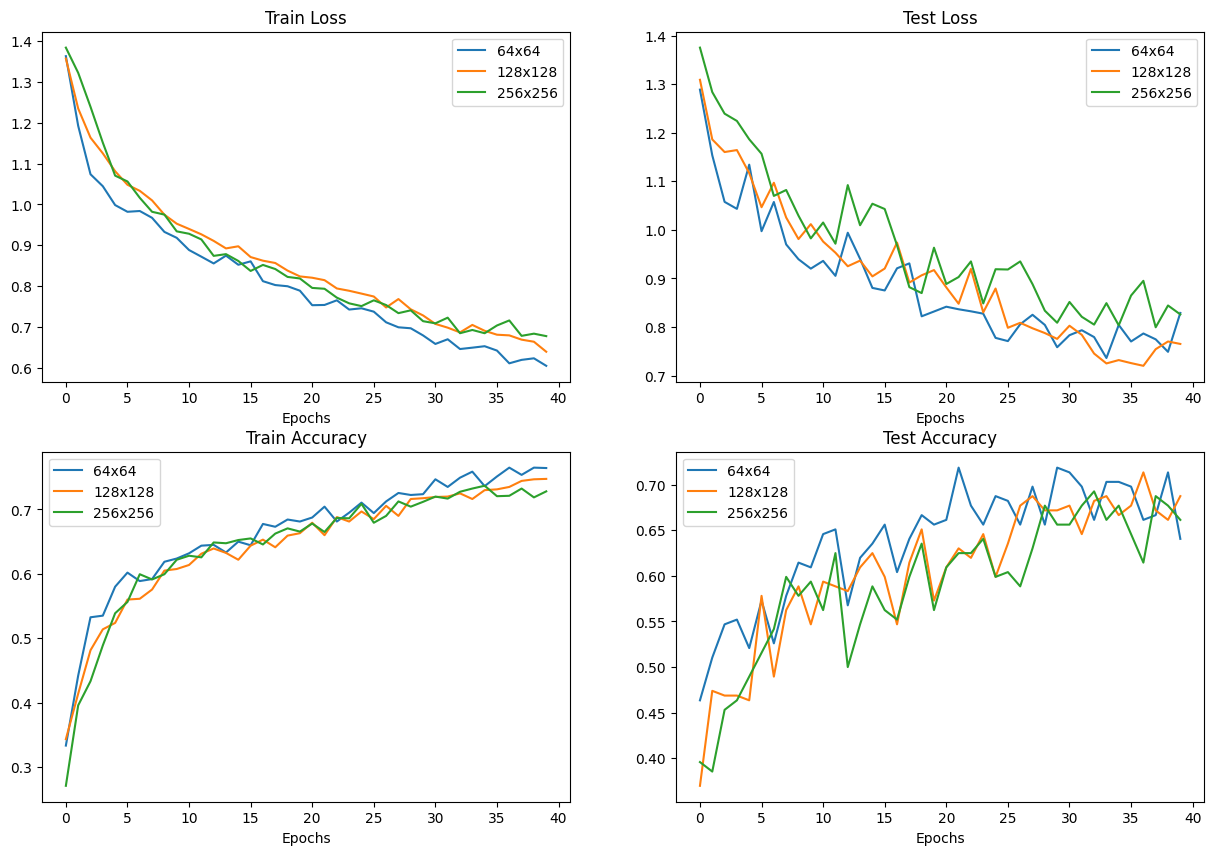

In [26]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(df_64x64))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, df_64x64["train_loss"], label="64x64")
plt.plot(epochs, df_128x128["train_loss"], label="128x128")
plt.plot(epochs, df_256x256["train_loss"], label="256x256")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, df_64x64["test_loss"], label="64x64")
plt.plot(epochs, df_128x128["test_loss"], label="128x128")
plt.plot(epochs, df_256x256["test_loss"], label="256x256")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, df_64x64["train_acc"], label="64x64")
plt.plot(epochs, df_128x128["train_acc"], label="128x128")
plt.plot(epochs, df_256x256["train_acc"], label="256x256")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, df_64x64["test_acc"], label="64x64")
plt.plot(epochs, df_128x128["test_acc"], label="128x128")
plt.plot(epochs, df_256x256["test_acc"], label="256x256")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

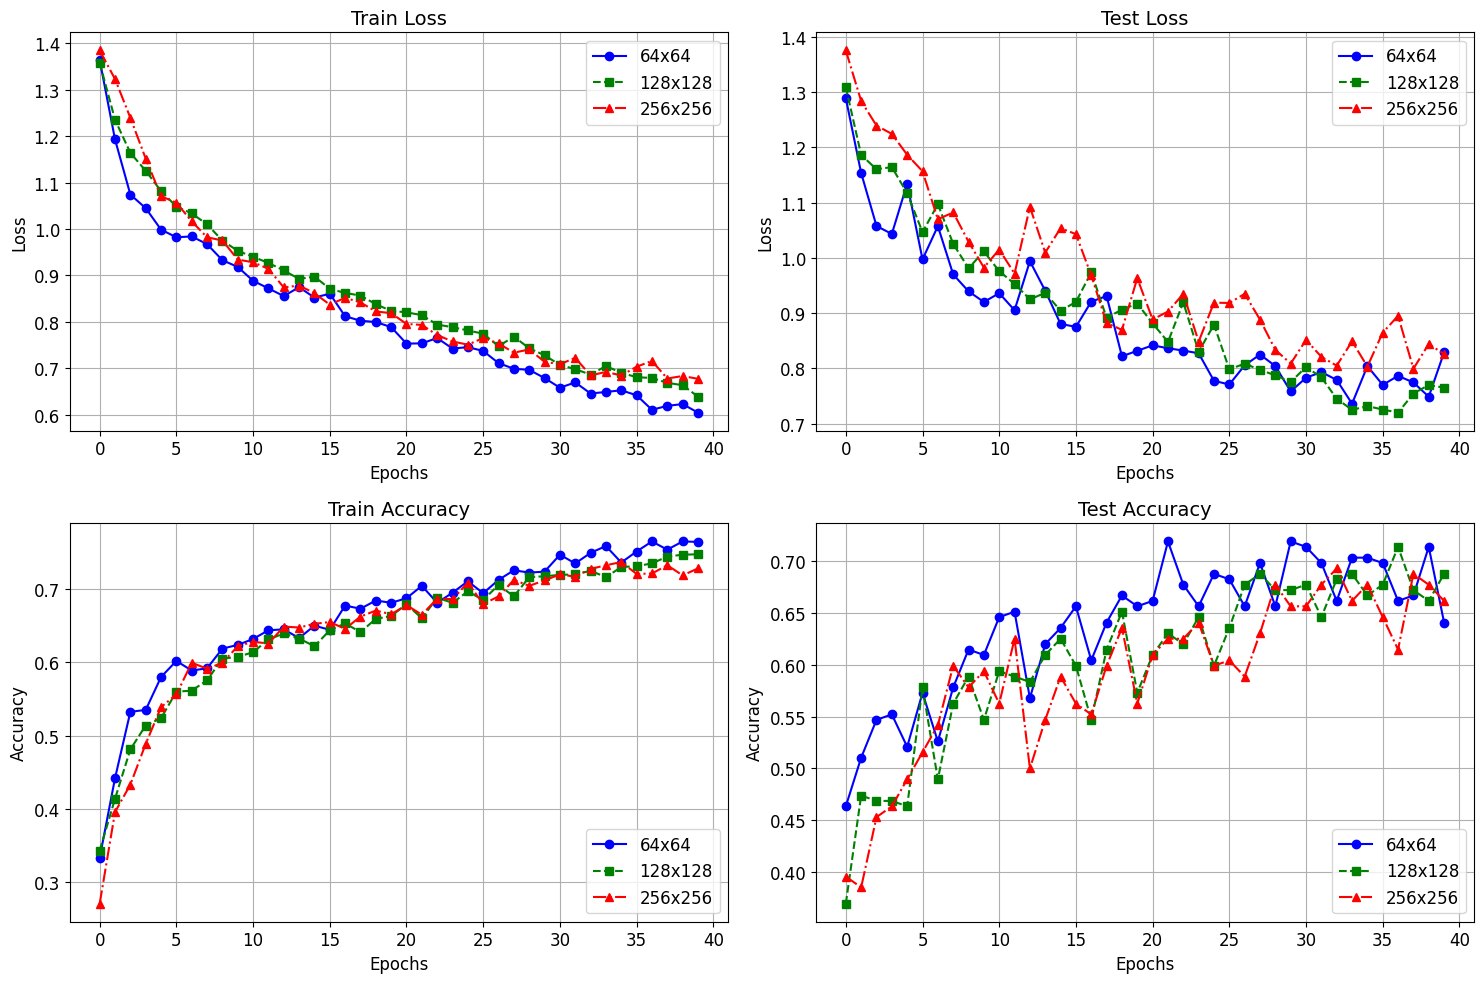

In [38]:
# Setup a plot with larger size for clarity
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(df_64x64))

# Customize plot appearance
plt.rcParams.update({'font.size': 12})

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, df_64x64["train_loss"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128["train_loss"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256["train_loss"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Train Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(loc="upper right")

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, df_64x64["test_loss"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128["test_loss"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256["test_loss"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Test Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(loc="upper right")

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, df_64x64["train_acc"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128["train_acc"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256["train_acc"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Train Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, df_64x64["test_acc"], label="64x64", linestyle='-', marker='o', color='b')
plt.plot(epochs, df_128x128["test_acc"], label="128x128", linestyle='--', marker='s', color='g')
plt.plot(epochs, df_256x256["test_acc"], label="256x256", linestyle='-.', marker='^', color='r')
plt.title("Test Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="lower right")

# Adjust layout
plt.tight_layout()
plt.show()

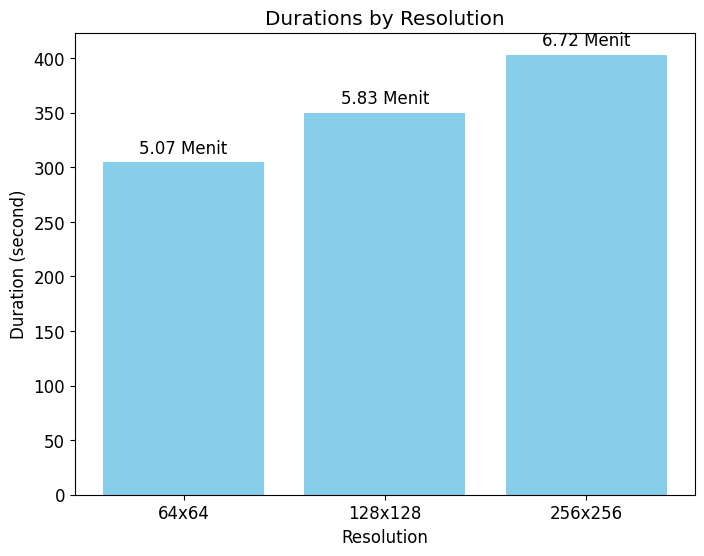

In [45]:
data_durasi = [duration_64x64, duration_128x128, duration_256x256]
labels = ['64x64', '128x128', '256x256']

# Plotting histogram
plt.figure(figsize=(8,6))
bars = plt.bar(labels, data_durasi, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval/60:.2f} Menit', ha='center', va='bottom')


plt.xlabel('Resolution')
plt.ylabel('Duration (second)')
plt.title('Durations by Resolution')
plt.show()